# LSTM降雨径流建模

本节给出一个关于如何建立和训练LSTM-CAMELS模型的例子。如果你使用了平台提供的jupyterlab，那就能直接使用平台上的GPU计算资源来完成相应的计算。因为我们会有一些人同时运行代码，所以为了避免机器资源不够，以及快速地交互给出结果，这里只给出了少量流域上训练测试模型的示例，更多流域的完整复现Kratzert等{cite}`hess-22-6005-2018`论文的例子也是一样的，大家可以自行尝试。

## 1 LSTM-CAMELS简介

首先，我们简单看看模型输入输出以及模型结构，如下图所示，左边是数据集数据情况，右边是模型的基本结构，中间深蓝色箭头表示哪些数据以什么形式送入模型中。

CAMELS数据集包含的流域层面数据有径流数据、流域平均的气象时间序列数据和流域平均的气候地理属性数据；

其中，属性数据也能为建模提供帮助（可以参考Kratzert等另一篇文章 {cite}`hess-23-5089-2019`），因为LSTM接受的是时序输入，所以需要把它们复制到每个时段和其他时序输入拼接在一起后送入LSTM模型；径流数据就在训练中用于和模型输出比较计算损失函数值。

LSTM模型前面已经有介绍过基本原理了，这里简单介绍Kratzert等{cite}`hess-22-6005-2018`论文中的模型，也就是图中所示的结构。

论文中模型由两层LSTM堆叠而成，LSTM最后一个时段的输出会进入到一个线性层（Dense Layer），输出一个神经元值，它就是预测的径流。输出的虚线部分意思是每个时段均有LSTM隐含层输出，只是这里我们只用了最后一个时段的输出。

![](../img/LSTM-CAMELS.png)

## 2 获取CAMELS数据

在开始正式实现LSTM-CAMELS之前，我们需要先获取CAMELS数据，为了方便大家使用CAMELS数据，我们已经将数据下载到平台服务器了，并且打包了读取CAMELS数据的代码，还将其内置在目前的python环境下了，所以我们现在直接写一些简单的调用代码就能读取CAMELS数据了。

因为我们的包还不知道下载的CAMELS数据集在哪，所以开始前需要设置一个配置文件，运行以下代码即可：

In [6]:
import hydrodataset

接下来，我们需要手动修改这个配置文件，让后续代码知道CAMELS数据在哪，如果你在前面[第二章](https://iheadwater.github.io/iheadwater_hackweek_tutorials/chp2_file_formats/chp2.3_raster_data.html)有跟着一起操作，那这里就不用再做什么了，否则需要跟着下面的内容一起操作。

在平台jupyterlab首页打开终端，然后输入以下命令打开hydrodataset配置文件：

```Shell
# 进入配置文件所在文件夹
cd ~/.hydrodataset
# 使用vim打开配置文件
vim settings.txt
```

打开后，按“i”键，将vim编辑器调整至INSERT模式，如下图所示：

![](../img/vim_insert.png)

然后输入和上图中一样的内容，即 `/ftproot`，ftproot是我们在服务器上放置公共数据的默认文件夹，处理好的CAMELS数据集文件都在这个文件夹下面。

然后再按“:”（注意是英文输入法下的冒号）进入命令模式，然后输入“wq”并按回车键，就能写入（即保存）并退出了。

![](../img/vim_wq.png)

接下来我们就可以试试读取CAMELS数据集了

In [7]:
import os
from hydrodataset.camels import Camels

camels_us_path = os.path.join("camels", "camels_us")
us_region = "US"
camels_us = Camels(camels_us_path, region=us_region)

In [5]:
camels_us.camels_sites.head()

,gauge_id,huc_02,gauge_name
0,01013500,01,"Fish River near Fort Kent, Maine"
1,01022500,01,"Narraguagus River at Cherryfield, Maine"
2,01030500,01,"Mattawamkeag River near Mattawamkeag, Maine"
3,01031500,01,"Piscataquis River near Dover-Foxcroft, Maine"
4,01047000,01,"Carrabassett River near North Anson, Maine"


因为CAMELS文件都是txt格式，每次都直接读取txt速度会比较慢，所以我们提供了存数据到能快速读取的二进制数据格式文件的方法。

这一步我们已经提前做好了，数据文件在前面用到的frproot下的camels/camels_us文件夹下了，所以这里我们直接使用它。

径流和气象数据文件是netcdf（简称nc）格式，使用n格式的原因是：如果把所有变量一次都读进内存，数据量还是有点大，所以这里我们使用一个名叫xarray的包来读取nc文件，这样我们就能懒加载数据了，即不必一次性把所有数据加载到内存中，而是在使用到哪一部分数据时，再把那一部分数据加载进来。虽然本节后续示例中我们实际上没用多少流域，但是这里还是推荐这种方式，以后做深度学习应用研究，这应是一种比较常见的方式。

属性数据是feather格式，也是一种读写比较快的文件类型，用pandas即可打开。

In [17]:
data_dir = camels_us.data_source_dir
data_dir

PosixPath('/ftproot/camels/camels_us')

In [ ]:
cache_dir = hydrodataset.CACHE_DIR
cache_dir

PosixPath('/home/ouyangwenyu/.hydrodataset/cache')

In [32]:
import pandas as pd
import xarray as xr

In [68]:
streamflow_ds = xr.open_dataset(data_dir.joinpath("camels_streamflow.nc"))

In [69]:
streamflow_ds

<xarray.Dataset>
Dimensions:     (basin: 671, time: 12784)
Coordinates:
  * basin       (basin) object '01013500' '01022500' ... '14362250' '14400000'
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    streamflow  (basin, time) float64 ...

<AxesSubplot:xlabel='time'>

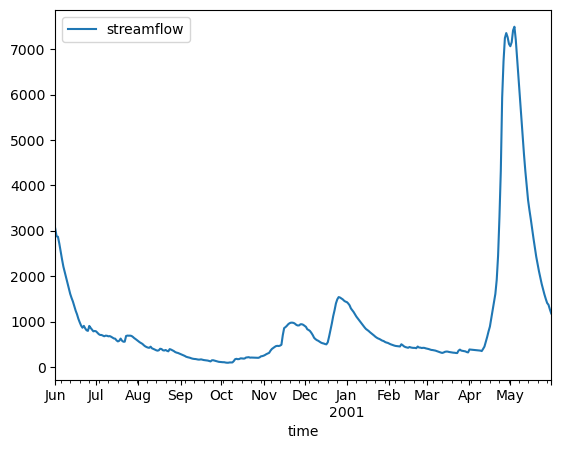

In [88]:
streamflow_ds.sel(
    basin="01013500", time=slice("2000-06-01", "2001-05-31")
).to_pandas().plot()

In [70]:
forcing_ds = xr.open_dataset(data_dir.joinpath("camels_daymet_forcing.nc"))
forcing_ds

<xarray.Dataset>
Dimensions:  (basin: 671, time: 12784)
Coordinates:
  * basin    (basin) object '01013500' '01022500' ... '14362250' '14400000'
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    dayl     (basin, time) float64 ...
    prcp     (basin, time) float64 ...
    srad     (basin, time) float64 ...
    swe      (basin, time) float64 ...
    tmax     (basin, time) float64 ...
    tmin     (basin, time) float64 ...
    vp       (basin, time) float64 ...
Attributes:
    forcing_type:  daymet

In [77]:
attrs = pd.read_feather(data_dir.joinpath("camels_attributes_v2.0.feather"))

In [79]:
attrs.head()

,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,...,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99
0,01013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,...,2303.95,0.9063,4.167304,3.340732,0.804567,0.371648,0.883452,Mixed Forests,NaN,NaN
1,01022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,...,620.38,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444
2,01030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,...,3676.09,0.8782,4.685200,3.665543,0.858502,0.351393,0.975258,Mixed Forests,NaN,NaN
3,01031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,...,766.53,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000
4,01047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,...,904.94,0.9906,5.086811,4.300978,0.891383,0.445473,0.850450,Mixed Forests,0.241027,2.340180


In [81]:
attrs.columns

Index(['gauge_id', 'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
       'aridity', 'high_prec_freq', 'high_prec_dur', 'high_prec_timing',
       'low_prec_freq', 'low_prec_dur', 'low_prec_timing', 'geol_1st_class',
       'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_porostiy', 'geol_permeability', 'q_mean',
       'runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
       'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
       'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity',
       'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac',
       'clay_frac', 'water_frac', 'organic_frac', 'other_frac', 'gauge_lat',
       'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'area_geospa_fabric', 'frac_forest', 'lai_max', 'lai_diff', 'gvf_max',
       'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover', 'roo

## 3 PyTorch实现LSTM-CAMELS

接下来，我们使用PyTorch来具体实现该模型，本节代码重点参考了：[kratzert/pangeo_lstm_example](https://github.com/kratzert/pangeo_lstm_example/blob/master/LSTM_for_rainfall_runoff_modelling.ipynb)

In [162]:
# 导入后续会用到的包
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from hydrodataset.camels import Camels
import HydroErr as he

In [147]:
# 平台提供了GPU计算资源
DEVICE = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # check if GPU is available

### 3.1 用PyTorch Dataset与Dataloader组织CAMELS数据

首先，构建读取CAMELS数据集数据的PyTorch Dataset和Dataloader.

模型训练时，会将样本分成一系列小批次（mini-batch），并使用随机梯度下降类算法完成各小批次的梯度下降计算。在计算机中执行运算时，每批次的输入数据会被组织成样本-时段-变量的三维数组，即tensor。其中，第一维的长度表示从总体样本中随机选择出的一部分样本的数目，即批次大小；第二维的长度表示LSTM的时序变量时段长度，训练中该长度是固定的；第三维代表各类型的输入变量。例如，数据集总流域数是100个，训练时间总长是1000天，变量共10种，一个批次时段长选择100天，则总样本数量就是100 \*（1000-100+1），如果每个批次中包含从总样本中随机抽取的10个样本，那么每个样本就是数据量为100天\*10个变量的二维张量，一个批次就是数据量为10\*100\*10的张量。

Dataset和DataLoader就是处理这些内容的。

In [176]:
class CamelsDataset(Dataset):
    """Base data set class to load and preprocess data (batch-first) using PyTroch's Dataset"""

    def __init__(
        self,
        basins: list,
        dates: list,
        data_attr: pd.DataFrame,
        data_forcing: xr.Dataset,
        data_flow: xr.Dataset,
        loader_type: str = "train",
        seq_length: int = 100,
        means: pd.DataFrame = None,
        stds: pd.DataFrame = None,
    ):
        """
        Initialize Dataset containing the data of multiple basins.

        Parameters
        ----------
        basins : list
            _description_
        dates : list
            _description_
        data_attr : pd.DataFrame
            _description_
        data_forcing : xr.Dataset
            _description_
        data_flow : xr.Dataset
            _description_
        loader_type : str, optional
            _description_, by default "train"
        seq_length : int, optional
            _description_, by default 100
        means : pd.DataFrame, optional
            _description_, by default None
        stds : pd.DataFrame, optional
            _description_, by default None

        Raises
        ------
        ValueError
            _description_
        """
        super(CamelsDataset, self).__init__()
        if loader_type not in ["train", "valid", "test"]:
            raise ValueError(
                " 'loader_type' must be one of 'train', 'valid' or 'test' "
            )
        else:
            self.loader_type = loader_type
        self.basins = basins
        self.dates = dates

        self.seq_length = seq_length

        self.means = means
        self.stds = stds

        self.data_attr = data_attr
        self.data_forcing = data_forcing
        self.data_flow = data_flow

        # load and preprocess data
        self._load_data()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, item: int):
        basin, time = self.lookup_table[item]
        seq_length = self.seq_length
        x = (
            self.x.sel(
                basin=basin,
                time=slice(time, time + np.timedelta64(seq_length - 1, "D")),
            )
            .to_array()
            .to_numpy()
        ).T
        c = self.c.loc[basin].values
        c = np.tile(c, (seq_length, 1))
        xc = np.concatenate((x, c), axis=1)
        y = (
            self.y.sel(
                basin=basin,
                time=time + np.timedelta64(seq_length - 1, "D"),
            )
            .to_array()
            .to_numpy()
        )
        return torch.from_numpy(xc).float(), torch.from_numpy(y).float()

    def _load_data(self):
        """load data from nc and feather files"""
        if self.loader_type == "train":
            train_mode = True
            df_mean_forcings = self.data_forcing.mean().to_pandas()
            df_std_forcings = self.data_forcing.std().to_pandas()
            df_mean_streamflow = self.data_flow.mean().to_pandas()
            df_std_streamflow = self.data_flow.std().to_pandas()
            df_mean_attr = self.data_attr.mean()
            df_std_attr = self.data_attr.std()
            self.means = pd.concat([df_mean_forcings, df_mean_attr, df_mean_streamflow])
            self.stds = pd.concat([df_std_forcings, df_std_attr, df_std_streamflow])
        else:
            train_mode = False

        # nomalization
        self.x = self._local_normalization(
            self.data_forcing, list(self.data_forcing.keys())
        )
        self.c = self._local_normalization(
            self.data_attr, self.data_attr.columns.values.tolist()
        )
        if train_mode:
            self.y = self._local_normalization(
                self.data_flow, list(self.data_flow.keys())
            )
        else:
            self.y = self.data_flow
        self.train_mode = train_mode
        self._create_lookup_table()

    def _local_normalization(self, feature, variable) -> np.ndarray:
        """Normalize features with local mean/std."""
        feature = (feature - self.means[variable]) / self.stds[variable]
        return feature

    def _create_lookup_table(self):
        """create a index table for __getitem__ functions"""
        lookup = []
        # list to collect basins ids of basins without a single training sample
        seq_length = self.seq_length
        dates = self.data_flow["time"].to_numpy()
        time_length = len(dates)
        for basin in self.basins:
            for j in range(time_length - seq_length + 1):
                lookup.append((basin, dates[j]))
        self.lookup_table = {i: elem for i, elem in enumerate(lookup)}
        self.num_samples = len(self.lookup_table)

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

    def local_denormalization(self, feature, variable="streamflow"):
        """revert the normalization for streaflow"""
        feature = feature * self.stds[variable] + self.means[variable]
        return feature

### 3.2 搭建LSTM模型

借助已有的神经网络模块，在PyTorch中实现一个深度学习模型是比较简单的。

In [177]:
class LSTM_CAMELS(nn.Module):
    """Implementation of a two-layer LSTM network"""

    def __init__(self, input_size, hidden_size: int, dropout_rate: float = 0.0):
        """Construct LSTM-CAMELS

        Parameters
        ----------
        input_size : _type_
            _description_
        hidden_size : int
            _description_
        dropout_rate : float, optional
            _description_, by default 0.0
        """
        super(LSTM_CAMELS, self).__init__()

        # create required layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            bias=True,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network"""
        output, (h_n, c_n) = self.lstm(x)

        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1, :, :]))
        return pred

## 4 训练模型

训练用的主函数

In [178]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch"""
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

验证期和后面测试期使用的调用训练后模型计算的函数

In [179]:
def eval_model(model, loader):
    """Evaluate the model"""
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)

    return torch.cat(obs), torch.cat(preds)

这里我们选择100个流域来试一试模型的性能，就直接选择数据集中按id排序的前100个，总的训练时间长度用10年数据，1995-2005年，气象数据我们选择 dayl, prcp, srad, tmax, tmin 和 vp 6种，属性数据我们选择 'p_mean', 'p_seasonality', 'frac_snow', 'aridity', 'geol_porostiy', 'geol_permeability'， 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'elev_mean', 'slope_mean', 'area_gages2','frac_forest', 'lai_max' 14种，当然你可以尝试别的变量组合。

In [180]:
def load_streamflow(ds_flow, ds_attr, basins, time_range):
    """load streamflow data in the time_range and transform its unit from ft3/s to mm/day

    Parameters
    ----------
    ds_flow : _type_
        _description_
    ds_attr : _type_
        _description_
    time_range : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    chosen_streamflow = ds_flow.sel(
        basin=basins, time=slice(time_range[0], time_range[1])
    )
    area = ds_attr["area_gages2"].values
    flow = (
        0.0283168
        * chosen_streamflow
        * 1000
        * 86400
        / (area.reshape(len(area), 1) * 10**6)
    )
    return flow

为了结果能复现，我们设置固定的随机种子

In [181]:
def set_random_seed(seed):
    """
    Set a random seed to guarantee the reproducibility

    Parameters
    ----------
    seed
        a number
    Returns
    -------
    None
    """
    print("Random seed:", seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [182]:
set_random_seed(1234)

Random seed: 1234


In [183]:
basins_num = 2

chosen_basins = camels_us.camels_sites["gauge_id"][:basins_num].values
train_times = ["1990-09-01", "2000-08-31"]
valid_times = ["2000-09-01", "2005-08-31"]
chosen_forcing_vars = ["dayl", "prcp", "srad", "tmax", "tmin", "vp"]
chosen_attrs_vars = [
    "p_mean",
    "p_seasonality",
    "frac_snow",
    "aridity",
    "geol_porostiy",
    "geol_permeability",
    "soil_depth_statsgo",
    "soil_porosity",
    "soil_conductivity",
    "elev_mean",
    "slope_mean",
    "area_gages2",
    "frac_forest",
    "lai_max",
]

In [184]:
# 需要的属性
chosen_attrs = attrs[attrs["gauge_id"].isin(chosen_basins)][
    ["gauge_id"] + chosen_attrs_vars
]
chosen_attrs = chosen_attrs.set_index("gauge_id")
chosen_attrs

,p_mean,p_seasonality,frac_snow,aridity,geol_porostiy,geol_permeability,soil_depth_statsgo,soil_porosity,soil_conductivity,elev_mean,slope_mean,area_gages2,frac_forest,lai_max
gauge_id,,,,,,,,,,,,,,
01013500,3.126679,0.18794,0.313440,0.630559,0.1714,-14.7019,1.248408,0.461149,1.106522,250.31,21.64152,2252.7,0.9063,4.167304
01022500,3.608126,-0.11453,0.245259,0.587356,0.0710,-14.2138,1.491846,0.415905,2.375005,92.68,17.79072,573.6,0.9232,4.871392


In [185]:
# 需要的气象时序数据
train_forcings = forcing_ds[chosen_forcing_vars].sel(
    basin=chosen_basins, time=slice(train_times[0], train_times[1])
)
valid_forcings = forcing_ds[chosen_forcing_vars].sel(
    basin=chosen_basins, time=slice(valid_times[0], valid_times[1])
)

In [186]:
# 需要的径流数据
# NOTE： 这里把径流单位转换为 mm/day
train_flow = load_streamflow(streamflow_ds, chosen_attrs, chosen_basins, train_times)
valid_flow = load_streamflow(streamflow_ds, chosen_attrs, chosen_basins, valid_times)

In [187]:
train_flow

<xarray.Dataset>
Dimensions:     (basin: 2, time: 3653)
Coordinates:
  * basin       (basin) object '01013500' '01022500'
  * time        (time) datetime64[ns] 1990-09-01 1990-09-02 ... 2000-08-31
Data variables:
    streamflow  (basin, time) float64 0.3877 0.3703 0.3432 ... 0.2517 0.2431

In [188]:
# settings
input_size = len(chosen_attrs_vars) + len(chosen_forcing_vars)
hidden_size = 10  # Number of LSTM cells
dropout_rate = 0.0  # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-3  # Learning rate used to update the weights
sequence_length = 100  # Length of the meteorological record provided to the network
batch_size = 32

# Training data
ds_train = CamelsDataset(
    basins=chosen_basins,
    dates=train_times,
    data_attr=chosen_attrs,
    data_forcing=train_forcings,
    data_flow=train_flow,
    loader_type="train",
    seq_length=sequence_length,
    means=None,
    stds=None,
)
tr_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
# Validation data
means = ds_train.get_means()
stds = ds_train.get_stds()
ds_val = CamelsDataset(
    basins=chosen_basins,
    dates=valid_times,
    data_attr=chosen_attrs,
    data_forcing=valid_forcings,
    data_flow=valid_flow,
    loader_type="valid",
    seq_length=sequence_length,
    means=means,
    stds=stds,
)
valid_batch_size = 1000
val_loader = DataLoader(ds_val, batch_size=valid_batch_size, shuffle=False)

# Here we create our model, feel free
model = LSTM_CAMELS(
    input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

执行训练函数

In [189]:
n_epochs = 2  # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i + 1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_denormalization(preds.cpu().numpy(), variable="streamflow")
    obs = obs.numpy().reshape(basins_num, -1)
    preds = preds.reshape(basins_num, -1)
    nse = np.array([he.nse(preds[i], obs[i]) for i in range(obs.shape[0])])
    tqdm.notebook.tqdm.write(f"Validation NSE mean: {nse.mean():.2f}")

  0%|          | 0/223 [00:00<?, ?it/s]

Validation NSE mean: 0.58


  0%|          | 0/223 [00:00<?, ?it/s]

Validation NSE mean: 0.68


## 5 评价模型

最后，我们来看看如何评价模型

In [190]:
# Evaluate on test set
test_times = ["2005-09-01", "2010-08-31"]
test_forcings = forcing_ds[chosen_forcing_vars].sel(
    basin=chosen_basins, time=slice(test_times[0], test_times[1])
)
test_flow = load_streamflow(streamflow_ds, chosen_attrs, chosen_basins, test_times)
ds_test = CamelsDataset(
    basins=chosen_basins,
    dates=test_times,
    data_attr=chosen_attrs,
    data_forcing=test_forcings,
    data_flow=test_flow,
    loader_type="test",
    seq_length=sequence_length,
    means=means,
    stds=stds,
)
test_batch_size = 1000
test_loader = DataLoader(ds_test, batch_size=test_batch_size, shuffle=False)
obs, preds = eval_model(model, test_loader)
preds = ds_test.local_denormalization(preds.cpu().numpy(), variable="streamflow")
obs = obs.numpy().reshape(basins_num, -1)
preds = preds.reshape(basins_num, -1)
nse = np.array([he.nse(preds[i], obs[i]) for i in range(obs.shape[0])])

画图看看示例结果

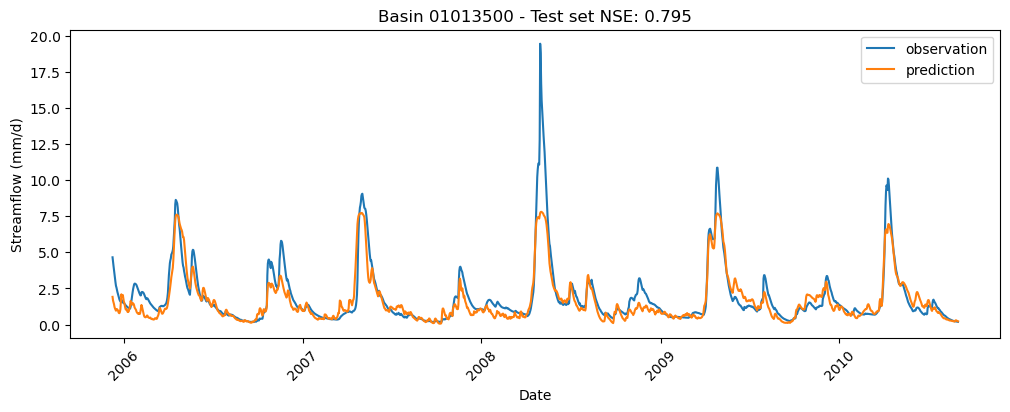

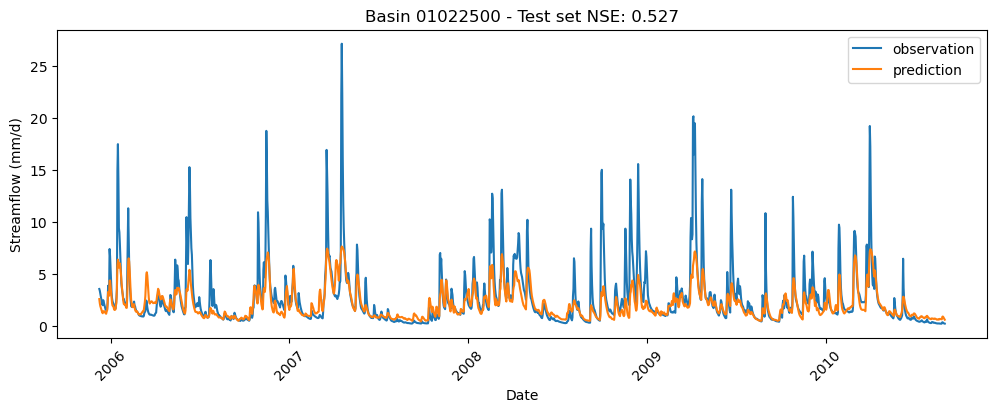

In [191]:
# Plot results
start_date = pd.to_datetime(ds_test.dates[0], format="%Y-%m-%d") + pd.DateOffset(
    days=sequence_length - 1
)
end_date = pd.to_datetime(ds_test.dates[1], format="%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
for i in range(basins_num):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_range, obs[i], label="observation")
    ax.plot(date_range, preds[i], label="prediction")
    ax.legend()
    ax.set_title(f"Basin {chosen_basins[i]} - Test set NSE: {nse[i]:.3f}")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("Date")
    _ = ax.set_ylabel("Streamflow (mm/d)")